

==== Modeling d^2x/dt^2 ====


C:\Users\alexi\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.892e+02, tolerance: 5.397e+00
  model = cd_fast.enet_coordinate_descent(



# === Lasso-selected coefficients ===
('x_t_0', -72.767607)
('x_t_1', 9.970130)
('x_t_2', 19.853485)
('x_t_3', 20.691529)
('x_t_4', 21.496002)
('x_t_0*x_t_0', 0.004457)
('x_t_0*x_t_0*x_t_0', 23.798777)
('x_t_0*x_t_0*x_t_1', -1.408638)
('x_t_0*x_t_0*x_t_2', -2.164900)
('x_t_0*x_t_0*x_t_3', -2.018881)
('x_t_0*x_t_0*x_t_4', -1.877614)
('x_t_0*x_t_1*x_t_1', 2.835992)
('x_t_0*x_t_1*x_t_2', -1.257132)
('x_t_0*x_t_1*x_t_3', -2.016590)
('x_t_0*x_t_1*x_t_4', -1.873902)
('x_t_0*x_t_2*x_t_2', 0.820240)
('x_t_0*x_t_2*x_t_3', -1.105790)
('x_t_0*x_t_2*x_t_4', -1.869041)
('x_t_0*x_t_3*x_t_3', -0.139636)
('x_t_0*x_t_3*x_t_4', -1.863052)
('x_t_0*x_t_4*x_t_4', -1.855995)
('x_t_1*x_t_1*x_t_1', 8.839786)
('x_t_1*x_t_1*x_t_2', -1.253382)
('x_t_1*x_t_1*x_t_3', -2.011235)
('x_t_1*x_t_1*x_t_4', -1.867106)
('x_t_1*x_t_2*x_t_2', 0.814796)
('x_t_1*x_t_2*x_t_3', -1.097973)
('x_t_1*x_t_2*x_t_4', -1.859535)
('x_t_1*x_t_3*x_t_3', -0.138398)
('x_t_1*x_t_3*x_t_4', -1.850799)
('x_t_1*x_t_4*x_t_4', -1.840960)
('x_t_2*x

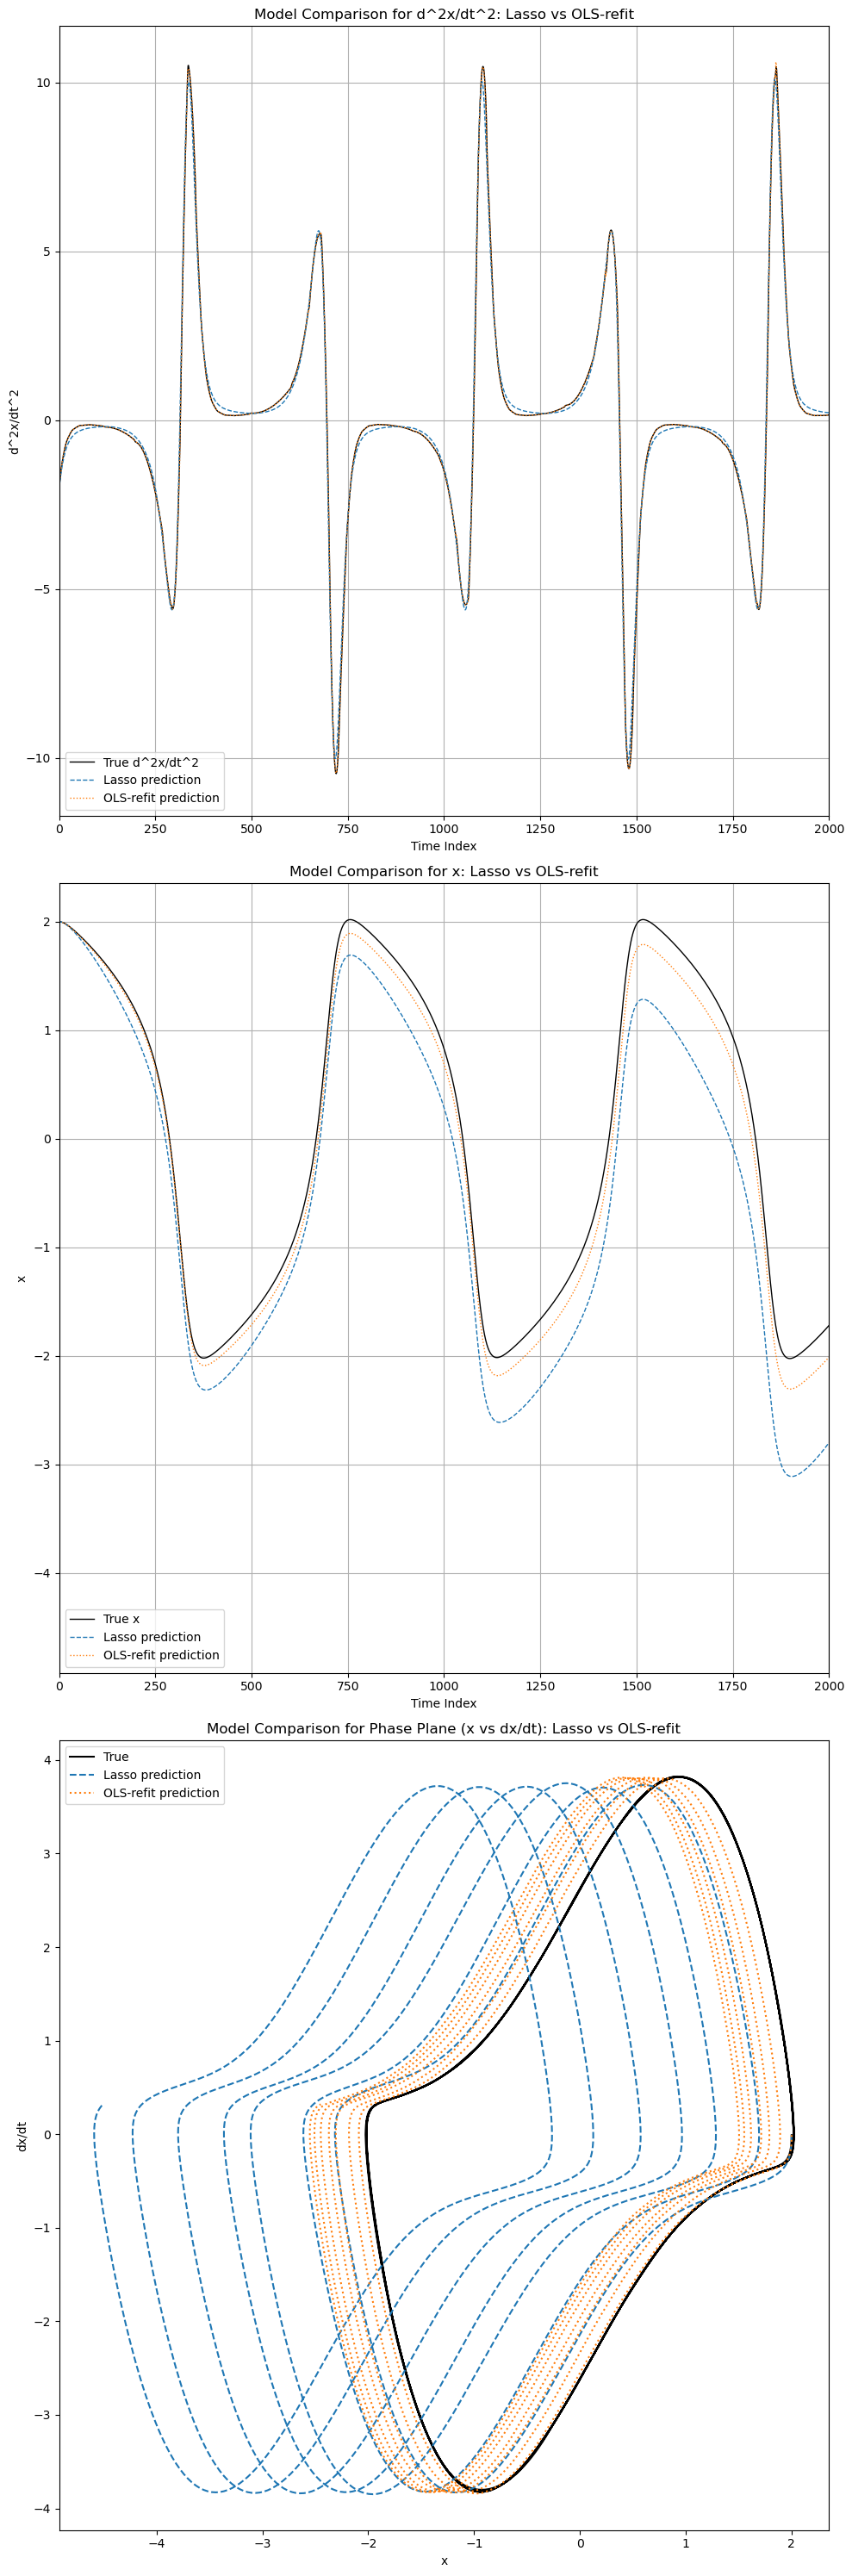

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SequentialFeatureSelector
from itertools import combinations_with_replacement

# 1. Simulate the Van der Pol system
def van_der_pol_forcing(t, y, mu, C, D):
    x, v = y
    dxdt = v
    dvdt = mu * (1 - x**2) * v - x + C * t + D * np.sin(t)
    return [dxdt, dvdt]

mu, C, D = 2, 0, 0
t_eval = np.linspace(0, 50, 5001)
sol = solve_ivp(van_der_pol_forcing, (0,50), [2.0, 0.0], args=(mu, C, D), t_eval=t_eval)
time, x, v = sol.t, sol.y[0], sol.y[1]

# 2. Compute true second derivative (d^2x/dt^2)
d2xdt2_true = mu * (1 - x**2) * v - x + C * time + D * np.sin(time)

# 3. Calculate approximate second derivative using finite differences
dt = time[1] - time[0]
dxdt = np.gradient(x, dt)  # First derivative
d2xdt2 = np.gradient(dxdt, dt)  # Second derivative

# # Add noise to approximated second derivative
# np.random.seed(0)
# d2xdt2 += np.random.normal(0, 0.1, size=d2xdt2.shape)

# 4. Create delay embedding using only x
def create_embedding(x, tau, d):
    N = len(x) - (d - 1) * tau
    emb = np.zeros((N, d))  # d delays of x
    for i in range(d):
        emb[:, i] = x[i*tau : i*tau + N]
    return emb

tau = 1
embedding_dim = 5  # Need at least 2 delays for second-order system
degree = 3
threshold = 1e-5

embedding = create_embedding(x, tau, embedding_dim)
embedding = embedding[:-1]  # To match derivative length

d2xdt2_target = d2xdt2[:len(embedding)]
x_true = x[:len(embedding)]

# 5. Build polynomial feature matrix
poly = PolynomialFeatures(degree=degree, include_bias=True)
Theta = poly.fit_transform(embedding)

# 6. Generate input symbol names dynamically
input_symbols = [f'x_t_{i*tau}' for i in range(embedding_dim)]

feature_names = ['1'] + [
    "*".join(comb)
    for deg in range(1, degree + 1)
    for comb in combinations_with_replacement(input_symbols, deg)
]

# 7. Function to perform modeling process (modified for second derivative)
def model_derivative(Theta, target, feature_names, threshold, derivative_name):
    print(f"\n\n==== Modeling {derivative_name} ====")
    
    # Fit Lasso regression to recover a sparse model 
    lasso = Lasso(alpha=0.001, max_iter=10000).fit(Theta, target)

    # Display Lasso-selected features
    print("\n# === Lasso-selected coefficients ===")
    selected_idx = []
    for idx, coef in enumerate(lasso.coef_):
        if abs(coef) > threshold:
            print(f"('{feature_names[idx]}', {coef:.6f})")
            selected_idx.append(idx)
    
    # OLS + forward selection on Lasso-selected features
    def fit_ols_select(X, y, idxs):
        if len(idxs) <= 1:
            model = LinearRegression().fit(X[:, idxs], y)
            return model, np.array(idxs)
        sfs = SequentialFeatureSelector(
            LinearRegression(), direction='forward', scoring='r2', cv=5
        )
        sfs.fit(X[:, idxs], y)
        final_idxs = np.array(idxs)[sfs.get_support()]
        model = LinearRegression().fit(X[:, final_idxs], y)
        return model, final_idxs
    
    ols_model, final_idx = fit_ols_select(Theta, target, selected_idx)

    # Display OLS-refitted coefficients
    print("\n# === OLS-refitted coefficients ===")
    for i, idx in enumerate(final_idx):
        print(f"('{feature_names[idx]}', {ols_model.coef_[i]:.6f})")
    
    return lasso, ols_model, final_idx

# Model second derivative
lasso_d2xdt2, ols_d2xdt2, final_idx_d2xdt2 = model_derivative(
    Theta, d2xdt2_target, feature_names, threshold, 'd^2x/dt^2'
)

# Compare Lasso vs OLS predictions
lasso_d2xdt2_pred = lasso_d2xdt2.predict(Theta)
ols_d2xdt2_pred = ols_d2xdt2.predict(Theta[:, final_idx_d2xdt2])

# 8. State prediction using only x data
def predict_states(Theta, d2xdt2_model, d2xdt2_idx, x0, dxdt0, dt):
    N = len(Theta)
    x_pred = np.zeros(N+2)
    dxdt_pred = np.zeros(N+2)
    
    # Initial conditions
    x_pred[0] = x0
    dxdt_pred[0] = dxdt0
    
    # First step (use first embedded values)
    x_pred[1] = embedding[0,0]
    dxdt_pred[1] = (embedding[1,0] - embedding[0,0]) / dt
    
    for i in range(1, N):
        # Get current second derivative
        if isinstance(d2xdt2_model, LinearRegression):
            d2xdt2 = d2xdt2_model.predict(Theta[i-1:i, d2xdt2_idx])[0]
        else:
            d2xdt2 = d2xdt2_model.predict(Theta[i-1:i])[0]
        
        # Update states using finite differences
        dxdt_pred[i+1] = dxdt_pred[i] + d2xdt2 * dt
        x_pred[i+1] = x_pred[i] + dxdt_pred[i] * dt
    
    return x_pred[1:-1], dxdt_pred[1:-1]  # Trim initial conditions

# Calculate state predictions
dxdt0 = (x[1] - x[0]) / dt  # Approximate initial first derivative
x_pred_lasso, dxdt_pred_lasso = predict_states(
    Theta, lasso_d2xdt2, final_idx_d2xdt2, x[0], dxdt0, dt
)

x_pred_ols, dxdt_pred_ols = predict_states(
    Theta, ols_d2xdt2, final_idx_d2xdt2, x[0], dxdt0, dt
)

# 9. Create all plots
plt.figure(figsize=(10, 30))

# Second derivative plots
plt.subplot(3, 1, 1)
plt.plot(d2xdt2_target, label='True d^2x/dt^2', color='black', lw=1)
plt.plot(lasso_d2xdt2_pred, label='Lasso prediction', linestyle='--', lw=1)
plt.plot(ols_d2xdt2_pred, label='OLS-refit prediction', linestyle=':', lw=1)
plt.xlabel('Time Index')
plt.ylabel('d^2x/dt^2')
plt.xlim(0, 2000)
plt.title('Model Comparison for d^2x/dt^2: Lasso vs OLS-refit')
plt.legend()
plt.grid()

# State variable plots
plt.subplot(3, 1, 2)
plt.plot(x_true, label='True x', color='black', lw=1)
plt.plot(x_pred_lasso, label='Lasso prediction', linestyle='--', lw=1)
plt.plot(x_pred_ols, label='OLS-refit prediction', linestyle=':', lw=1)
plt.xlabel('Time Index')
plt.ylabel('x')
plt.xlim(0, 2000)
plt.title('Model Comparison for x: Lasso vs OLS-refit')
plt.legend()
plt.grid()

# Phase space plots (x vs dx/dt)
plt.subplot(3, 1, 3)
plt.plot(x_true, dxdt[:len(x_true)], color='black', label='True')
plt.plot(x_pred_lasso, dxdt_pred_lasso, label='Lasso prediction', linestyle='--')
plt.plot(x_pred_ols, dxdt_pred_ols, label='OLS-refit prediction', linestyle=':')
plt.xlabel('x')
plt.ylabel('dx/dt')
plt.title('Model Comparison for Phase Plane (x vs dx/dt): Lasso vs OLS-refit')
plt.legend()

plt.tight_layout()
plt.show()